**Chapter 3 – Binary Classification**

# Setup

This project requires Python 3.7 or above:

In [ ]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Just like in the previous chapter, let's define the default font sizes to make the figures prettier:

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/classification` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [ ]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [ ]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [ ]:
mnist.keys()  # extra code – we only use data and target in this notebook

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
X.shape

(70000, 784)

In [ ]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [ ]:
y.shape

(70000,)

In [ ]:
28 * 28

784

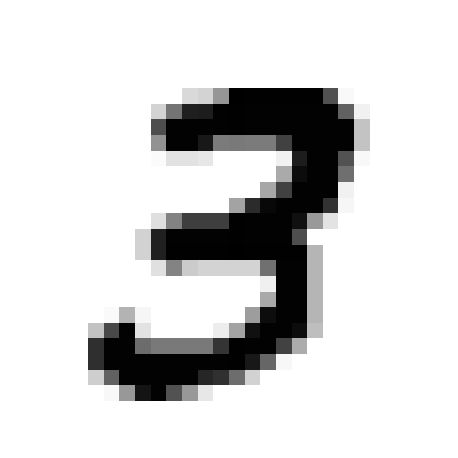

In [ ]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[7]
plot_digit(some_digit)
save_fig("some_digit_plot")  # extra code
plt.show()

In [ ]:
y[7]

'3'

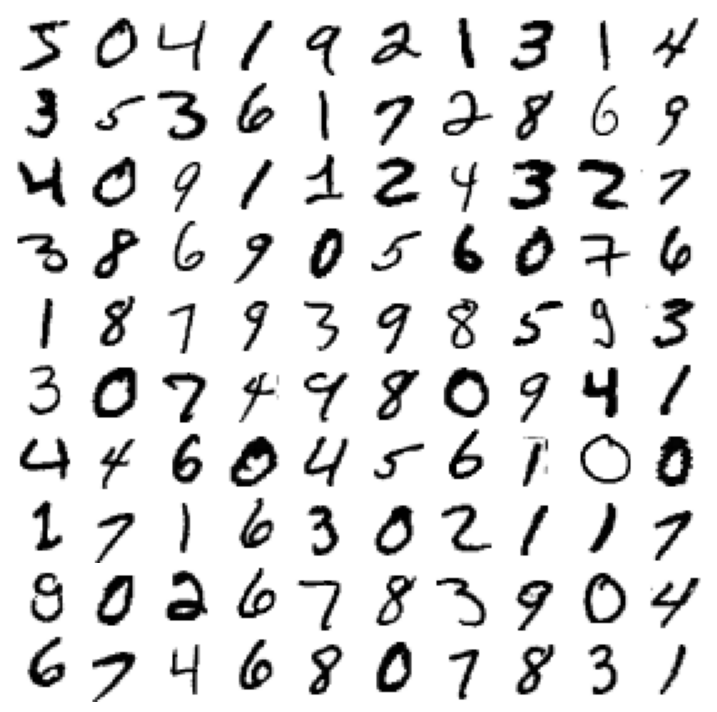

In [ ]:
# extra code – this cell generates and saves Figure 3–2
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [ ]:
y_train_3 = (y_train == '3')  # True for all 3s, False for all other digits
y_test_3 = (y_test == '3')

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_3)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

array([False])

In [ ]:
sgd_clf.predict([X[12]])

array([ True])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_3, cv=3, scoring="accuracy")

array([0.9496 , 0.9624 , 0.96275])

let’s look at a dummy classifier that just classifies every single image in the most frequent class, which in this case is the negative class (i.e., non 3):

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_3)
print(any(dummy_clf.predict(X_train)))

False


In [ ]:
cross_val_score(dummy_clf, X_train, y_train_3, cv=3, scoring="accuracy")

array([0.89785, 0.8978 , 0.8978 ])

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others). A much better way to evaluate the performance of a classifier is to look at the confusion matrix (CM).

## Confusion Matrix

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_3, y_train_pred)
cm

array([[53477,   392],
       [ 2113,  4018]])

The first row of this matrix considers non-3 images (the negative class): 53,477 of them were correctly classified as non-3s (they are called true negatives), while the remaining 392 were wrongly classified as 3s (false positives, also called type I errors). The second row considers the images of 3s (the positive class): 2,113 were wrongly classified as non-3s (false negatives, also called type II errors), while the remaining 4,018 were correctly classified as 3s (true positives).

## Precision and Recall

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_3, y_train_pred)  # == 4018 / (392 + 4018)

0.9111111111111111

In [ ]:
recall_score(y_train_3, y_train_pred)  # == 4018 / (2113 + 4018)

0.655358016636764

Now our 3-detector does not look as shiny as it did when we looked at its accuracy. When it claims an image represents a 3, it is correct only 91.1% of the time. Moreover, it only detects 65.5% of the 3s.

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train_3, y_train_pred)

0.7623565126648325

## Precision/Recall Trade-off

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3,
                             method="decision_function")

In [ ]:
threshold = 3000

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_3, y_scores)

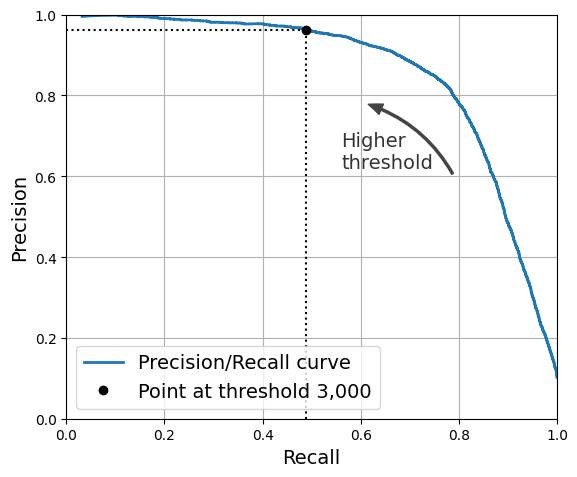

In [ ]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

In [ ]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(-411.44326592496236)

In [ ]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [ ]:
precision_score(y_train_3, y_train_pred_90)

0.9000870700914236

In [ ]:
recall_at_90_precision = recall_score(y_train_3, y_train_pred_90)
recall_at_90_precision

0.6744413635622247

## The ROC Curve

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_3, y_scores)

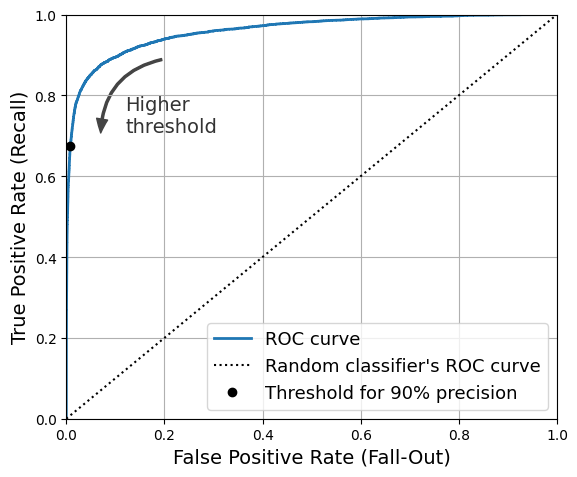

In [ ]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_3, y_scores)

np.float64(0.9599243001892759)

**Warning:** the following cell may take a few minutes to run.

Let’s now create a RandomForestClassifier, whose PR curve and F1 score we can compare to those of the SGDClassifier.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [ ]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv=3,
                                    method="predict_proba")

In [ ]:
y_probas_forest[:2]

array([[0.62, 0.38],
       [1.  , 0.  ]])

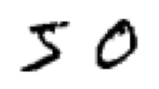

In [ ]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:2]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_3, y_scores_forest)

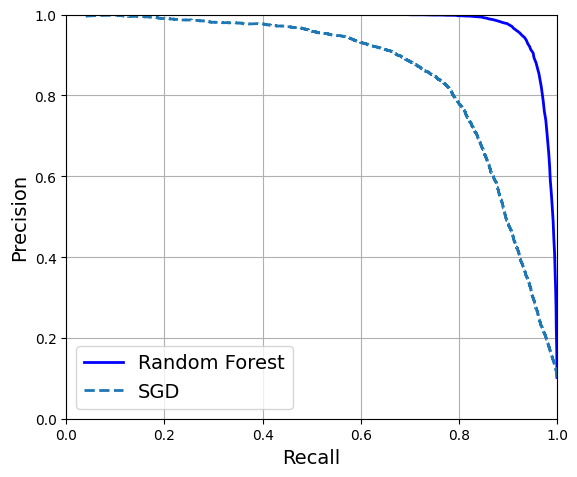

In [ ]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

We could use `cross_val_predict(forest_clf, X_train, y_train_3, cv=3)` to compute `y_train_pred_forest`, but since we already have the estimated probabilities, we can just use the default threshold of 50% probability to get the same predictions much faster:

In [ ]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_3, y_train_pred_forest)

0.9105216622458002

In [ ]:
roc_auc_score(y_train_3, y_scores_forest)

np.float64(0.995864544068936)

In [ ]:
precision_score(y_train_3, y_train_pred_forest)

0.9942073759413014

In [ ]:
recall_score(y_train_3, y_train_pred_forest)

0.8398303702495514